In [431]:
import requests, re, sys, os
#import urllib2
#import csv
import pandas as pd

from bs4 import BeautifulSoup
from datetime import datetime

from urllib.request import urlopen
import time
import matplotlib.pyplot as plt

from collections import Counter
import operator
import seaborn as sns
import socket
import pygeoip

from datetime import datetime
import matplotlib.ticker as ticker
from scipy import interpolate


In [75]:
df=pd.DataFrame(columns=['date','site','attacker','mirror','os'])

In [12]:


sess = requests.session()


#inspect code from zoneh.org to find the the cookie information
myCookie = {
    'ZHE':'080bc96da36cdc3f9beb99043ac3dce5',
  #  'ZH':'931be96f0472188542f55e28feea8b96',
    'PHPSESSID':'o4u9300abn6o42k1jh4vqgcoa0'
}




In [76]:

count=0
for i in range(1,51):
    print('Processing Page: ',i)
    
    url2=url+str(i)
    print(url2)
    
    data = sess.get(url2, cookies=myCookie)
    data2 = data.content
    bs = BeautifulSoup(data2, 'lxml')
    table_body = bs.find('table')
    rows = table_body.find_all('tr', class_=None)[1:]
    #count=0
    
    for row in rows:
            entry = row.findAll('td')

            if len(entry) > 1:
                
                date = entry[0].text
                attacker = entry[1].text
                site = entry[7].text
                os = entry[8].text
                mirror = entry[9].find('a').get('href')
               
                df.loc[count] = [date,site,attacker,mirror,os] 
                count+=1
    
    time.sleep(5) # Be nice with the webserver
   
          

Processing Page:  1
http://zone-h.org/archive/special=1/page=1
Processing Page:  2
http://zone-h.org/archive/special=1/page=2
Processing Page:  3
http://zone-h.org/archive/special=1/page=3
Processing Page:  4
http://zone-h.org/archive/special=1/page=4
Processing Page:  5
http://zone-h.org/archive/special=1/page=5
Processing Page:  6
http://zone-h.org/archive/special=1/page=6
Processing Page:  7
http://zone-h.org/archive/special=1/page=7
Processing Page:  8
http://zone-h.org/archive/special=1/page=8
Processing Page:  9
http://zone-h.org/archive/special=1/page=9
Processing Page:  10
http://zone-h.org/archive/special=1/page=10
Processing Page:  11
http://zone-h.org/archive/special=1/page=11
Processing Page:  12
http://zone-h.org/archive/special=1/page=12
Processing Page:  13
http://zone-h.org/archive/special=1/page=13
Processing Page:  14
http://zone-h.org/archive/special=1/page=14
Processing Page:  15
http://zone-h.org/archive/special=1/page=15
Processing Page:  16
http://zone-h.org/arch

In [79]:
df['site']=df['site'].apply(lambda x: str(x).replace('\n','').replace('\t',''))

In [82]:
df.head()

,date,site,attacker,mirror,os
0,2019/04/22,sanluis.gob.mx/k.php,./Xi4u7,/mirror/id/32351245,Linux
1,2019/04/22,absensi.kemendag.go.id/bitch.html,PekapuranBerjaya,/mirror/id/32351133,F5 Big-IP
2,2019/04/22,pkk.mubakab.go.id,Akbar dravinky,/mirror/id/32351102,Linux
3,2019/04/22,www.pped.ie.ufrj.br/media/,PRdV,/mirror/id/32346511,Linux
4,2019/04/22,www.app.ie.ufrj.br/media/,PRdV,/mirror/id/32346510,Linux


### Store the dataframe locally so we won't have to download it again...

In [91]:
df.to_csv('zoneh-data/zoneh-archive.csv')

In [427]:
len(df)

1250

### Check the dates of the attacks

In [422]:
def date_format_func(x):
    try:
        return datetime.strptime(x, "%Y/%m/%d").date()
    except:
        return pd.NaT
    

In [423]:
dailydf=df.groupby(['date']).size().reset_index(name='count')

In [424]:
dailydf['date']=dailydf['date'].apply(date_format_func)

In [425]:
dailydf.set_index('date', inplace=True)

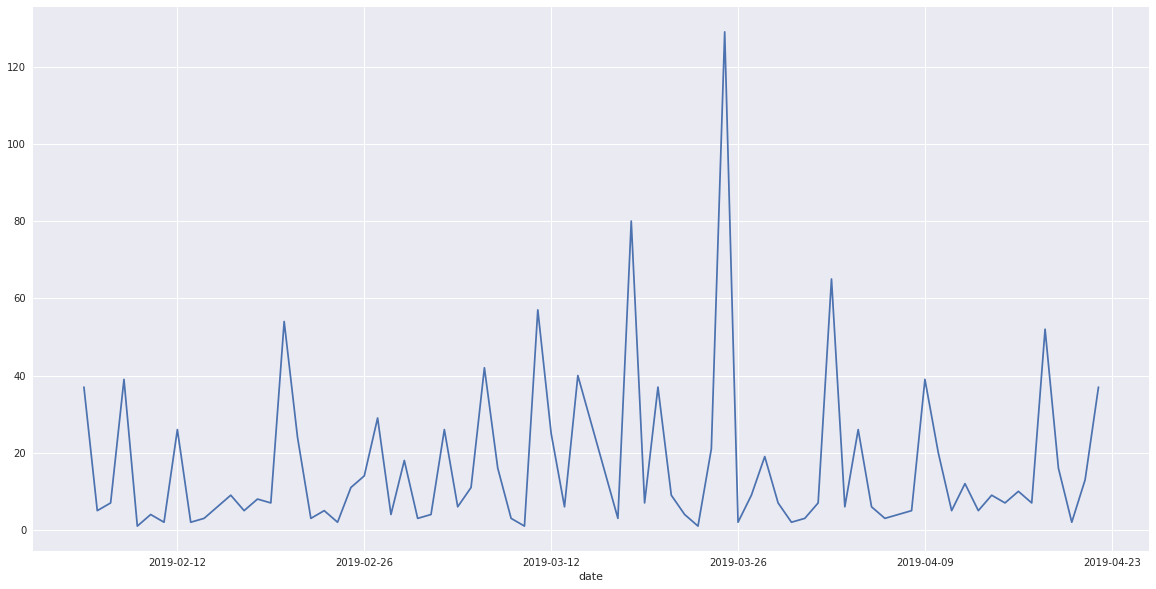

In [430]:
ax = plt.subplots(figsize=(20, 10))
ax = dailydf['count'].plot()
plt.show()

## check the stats of the attacked systems

In [187]:
def returnDict(column):
    mydict=dict(Counter(df[column]))
    mydict=sorted(mydict.items(), key=operator.itemgetter(1))
    mydict=mydict[::-1]
    return mydict

In [188]:
mydict=returnDict('os')

In [190]:
mydict

[('Linux', 972),
 ('Win 2012', 114),
 ('Unknown', 92),
 ('Win 2008', 42),
 ('FreeBSD', 10),
 ('F5 Big-IP', 8),
 ('Win 2016', 7),
 ('Win 2003', 4),
 ('MacOSX', 1)]

In [180]:
labels = [x[0] for x in mydict]
sizes = [x[1] for x in mydict]
explode= (0.2,0,0,0,0,0,0,0)


In [181]:
pcts=[]
for el in sizes:
    pcts.append(str(100*float(el)/sum(sizes))+' %')

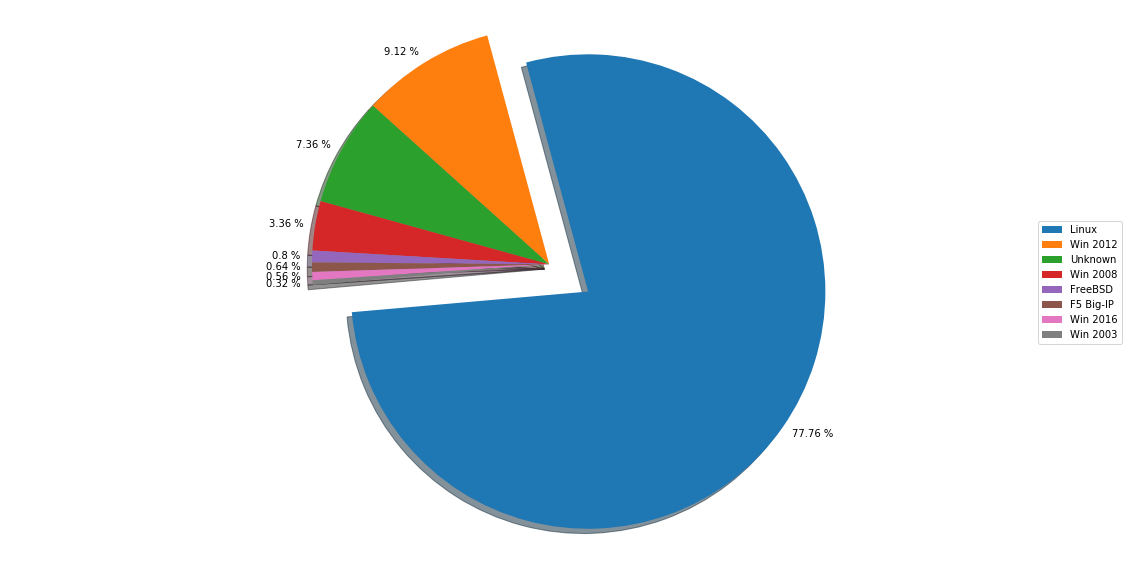

In [183]:

fig1, ax1 = plt.subplots(figsize=(20, 10))
patches = ax1.pie(sizes[:-1], explode=explode, shadow=True, startangle=185,labeldistance=1.05,labels=pcts[:-1] )

ax1.axis('equal')  
plt.legend(labels,loc='right');


plt.show()


### Top attackers

In [198]:
attackers=returnDict('attacker')

In [199]:
attackers=attackers[0:20]

In [201]:
tmp=pd.DataFrame(attackers)

In [203]:
tmp.columns=['Attacker','Defacements']

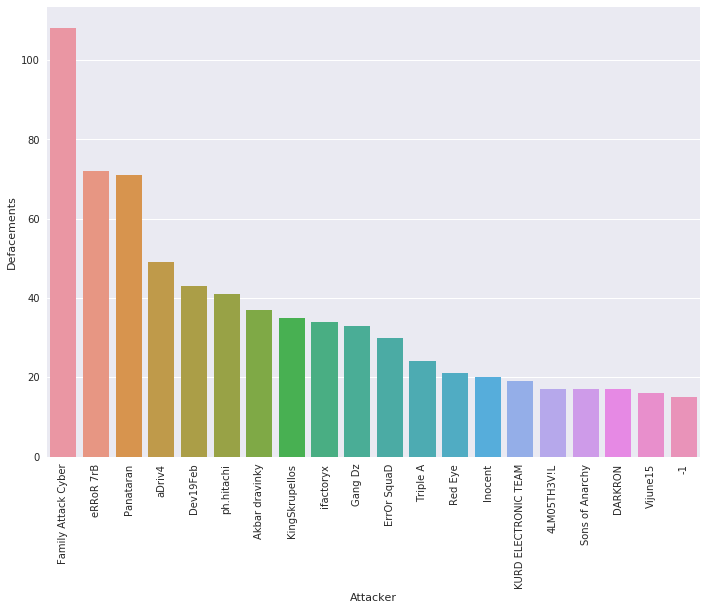

In [279]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(x="Attacker", y="Defacements", data=tmp)
ax.set_xticklabels(labels=tmp.Attacker.values,rotation=90);

# Location of systems

In [209]:
df.head()

,date,site,attacker,mirror,os
0,2019/04/22,sanluis.gob.mx/k.php,./Xi4u7,/mirror/id/32351245,Linux
1,2019/04/22,absensi.kemendag.go.id/bitch.html,PekapuranBerjaya,/mirror/id/32351133,F5 Big-IP
2,2019/04/22,pkk.mubakab.go.id,Akbar dravinky,/mirror/id/32351102,Linux
3,2019/04/22,www.pped.ie.ufrj.br/media/,PRdV,/mirror/id/32346511,Linux
4,2019/04/22,www.app.ie.ufrj.br/media/,PRdV,/mirror/id/32346510,Linux


In [211]:
srv_list1=df['site']
srv_list2=[]
for i in srv_list1:
    #print(i)
    j=re.sub(r'^https?\:\/\/', '', i, flags=re.I)
    j=j.split("/")[0]
    #print(j)
    srv_list2.append(j)

In [215]:
ip_list=[]
for i in srv_list2:
    try:
        ip=socket.gethostbyname(i)
        ip_list.append(ip)
        #print(str(i)+": "+str(ip))
    except:
        ip_list.append('0.0.0.0')

In [217]:
GEOIP1 = pygeoip.GeoIP("/home/bruck/geoip/GeoIP.dat", pygeoip.MEMORY_CACHE)
GEOIP2 = pygeoip.GeoIP("/home/bruck/geoip/GeoLiteCity.dat", pygeoip.MEMORY_CACHE)
GEOIP3 = pygeoip.GeoIP("/home/bruck/geoip/GeoIPASNum.dat", pygeoip.MEMORY_CACHE)

In [218]:
df['ip']=ip_list

df_tmp=pd.DataFrame()
for ip in ip_list:
    df_tmp=df_tmp.append(pd.DataFrame(GEOIP2.record_by_addr(ip),index=[0]))
df_tmp.reset_index(inplace=True)
result=pd.concat([df,df_tmp],axis=1)

In [432]:
result.head()

,date,site,attacker,mirror,os,ip,index,area_code,city,continent,country_code,country_code3,country_name,dma_code,latitude,longitude,metro_code,postal_code,region_code,time_zone
0,2019/04/22,sanluis.gob.mx/k.php,./Xi4u7,/mirror/id/32351245,Linux,104.27.148.208,0,0.0,None,NA,US,USA,United States,0.0,37.7510,-97.8220,None,None,None,None
1,2019/04/22,absensi.kemendag.go.id/bitch.html,PekapuranBerjaya,/mirror/id/32351133,F5 Big-IP,180.250.76.101,0,0.0,Tangerang,AS,ID,IDN,Indonesia,0.0,-6.1781,106.6300,None,None,30,Asia/Jakarta
2,2019/04/22,pkk.mubakab.go.id,Akbar dravinky,/mirror/id/32351102,Linux,103.105.195.230,0,0.0,None,AS,ID,IDN,Indonesia,0.0,3.5833,98.6667,None,None,26,Asia/Pontianak
3,2019/04/22,www.pped.ie.ufrj.br/media/,PRdV,/mirror/id/32346511,Linux,146.164.3.45,0,0.0,Rio De Janeiro,SA,BR,BRA,Brazil,0.0,-22.8751,-43.2775,None,None,21,America/Sao_Paulo
4,2019/04/22,www.app.ie.ufrj.br/media/,PRdV,/mirror/id/32346510,Linux,146.164.3.45,0,0.0,Rio De Janeiro,SA,BR,BRA,Brazil,0.0,-22.8751,-43.2775,None,None,21,America/Sao_Paulo


In [254]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

In [299]:
latlongframe=result.copy()
latlongframe=latlongframe[['latitude','longitude','country_name','continent']]

In [300]:
len(latlongframe)

1250

In [301]:
latlongframe=latlongframe.dropna()
len(latlongframe)

963

In [302]:
latlongframe=latlongframe.groupby(['latitude', 'longitude', 'country_name','continent']).size().reset_index(name='count')


In [303]:
latlongframe.head()

,latitude,longitude,country_name,continent,count
0,-41.0000,174.0000,New Zealand,OC,1
1,-34.6033,-58.3817,Argentina,SA,2
2,-34.6033,-58.3816,Argentina,SA,2
3,-34.5883,-58.6390,Argentina,SA,3
4,-32.9468,-60.6393,Argentina,SA,4


In [304]:
latlongframe['Coordinates'] = list(zip(latlongframe.longitude, latlongframe.latitude))

In [305]:
latlongframe.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,"(174.0, -41.0)"
1,-34.6033,-58.3817,Argentina,SA,2,"(-58.381699999999995, -34.60329999999999)"
2,-34.6033,-58.3816,Argentina,SA,2,"(-58.381600000000006, -34.60329999999999)"
3,-34.5883,-58.6390,Argentina,SA,3,"(-58.638999999999996, -34.588300000000004)"
4,-32.9468,-60.6393,Argentina,SA,4,"(-60.639300000000006, -32.946799999999996)"


In [306]:
#cities

In [307]:
latlongframe['Coordinates'] = latlongframe['Coordinates'].apply(Point)

In [308]:
latlongframe.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,POINT (174 -41)
1,-34.6033,-58.3817,Argentina,SA,2,POINT (-58.3817 -34.60329999999999)
2,-34.6033,-58.3816,Argentina,SA,2,POINT (-58.38160000000001 -34.60329999999999)
3,-34.5883,-58.6390,Argentina,SA,3,POINT (-58.639 -34.5883)
4,-32.9468,-60.6393,Argentina,SA,4,POINT (-60.63930000000001 -32.9468)


In [309]:
gdf = gpd.GeoDataFrame(latlongframe, geometry='Coordinates')

In [310]:
gdf.head()

,latitude,longitude,country_name,continent,count,Coordinates
0,-41.0000,174.0000,New Zealand,OC,1,POINT (174 -41)
1,-34.6033,-58.3817,Argentina,SA,2,POINT (-58.3817 -34.60329999999999)
2,-34.6033,-58.3816,Argentina,SA,2,POINT (-58.38160000000001 -34.60329999999999)
3,-34.5883,-58.6390,Argentina,SA,3,POINT (-58.639 -34.5883)
4,-32.9468,-60.6393,Argentina,SA,4,POINT (-60.63930000000001 -32.9468)


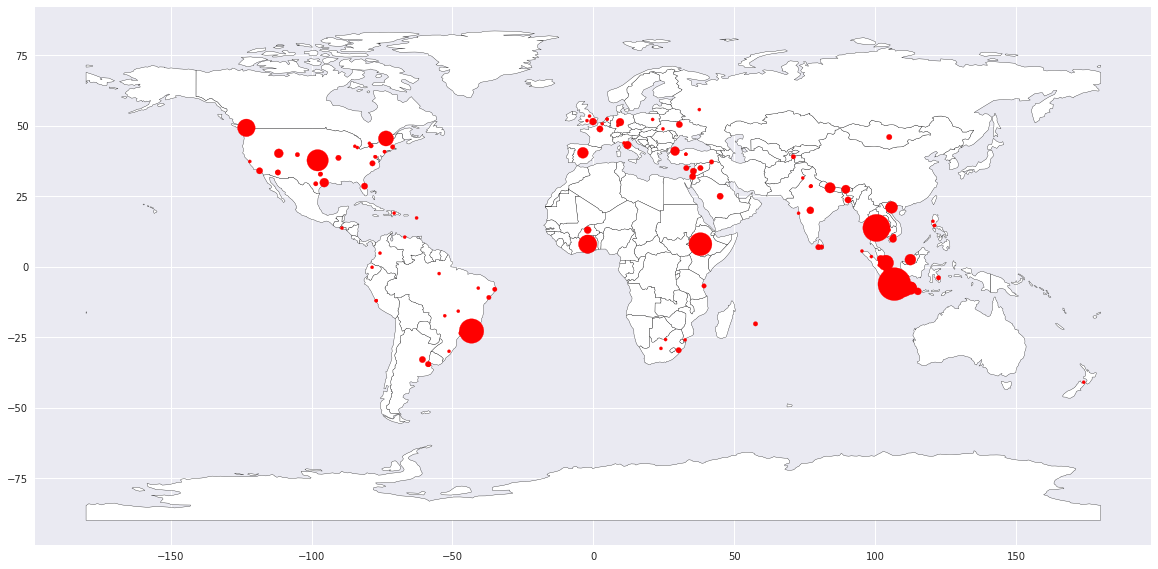

In [359]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black',figsize=(20,10))
gdf.plot(ax=ax, color='red',markersize=gdf['count']*10)
plt.show()

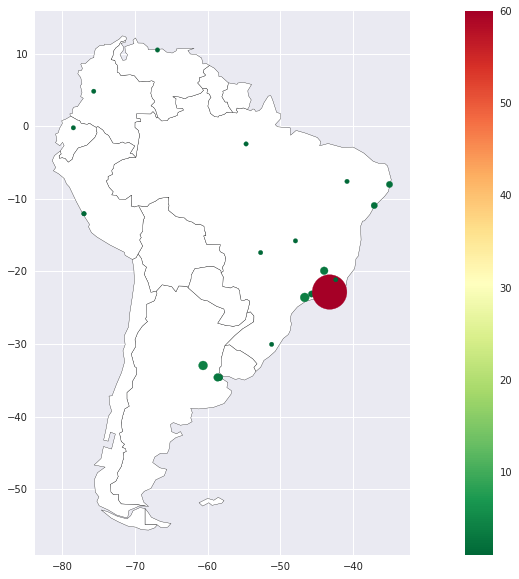

In [401]:
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black',figsize=(20,10))
tmp=gdf[gdf['continent']=='SA']
tmp.plot(ax=ax,cmap='RdYlGn_r',  column=tmp['count'] , markersize=tmp['count']*20,legend=True)
plt.show()